Загрузка данных, заполнение пропусков, обработка выбросов, удаление дубликатов

ApplicationDate               0
Age                           0
AnnualIncome                  0
CreditScore                   0
LoanAmount                    0
LoanDuration                  0
MaritalStatus                 0
NumberOfDependents            0
HomeOwnershipStatus           0
MonthlyDebtPayments           0
CreditCardUtilizationRate     0
NumberOfOpenCreditLines       0
NumberOfCreditInquiries       0
DebtToIncomeRatio             0
BankruptcyHistory             0
LoanPurpose                   0
PreviousLoanDefaults          0
PaymentHistory                0
LengthOfCreditHistory         0
SavingsAccountBalance         0
CheckingAccountBalance        0
TotalAssets                   0
TotalLiabilities              0
MonthlyIncome                 0
UtilityBillsPaymentHistory    0
JobTenure                     0
EmploymentStatus              0
EducationLevel                0
Experience                    0
NetWorth                      0
BaseInterestRate              0
Interest

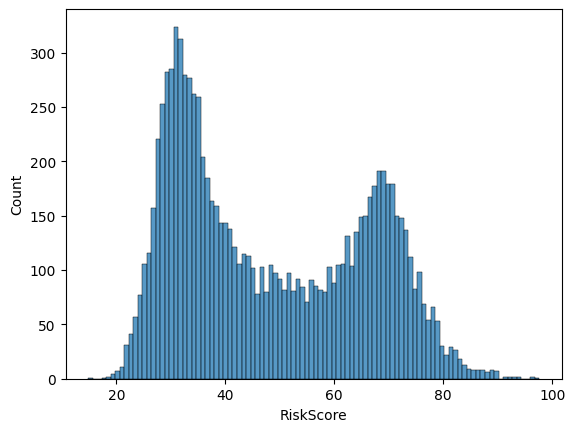

            Age   AnnualIncome  CreditScore     LoanAmount  LoanDuration  \
min   18.000000   15000.000000   300.000000    1063.000000     12.000000   
max   80.000000  748508.000000   850.000000  418997.000000    120.000000   
mean  39.853494  131612.620658   678.267634   29658.167552     53.366163   
std   11.585621  115782.168764   173.987015   26872.867667     24.463801   

      NumberOfDependents  MonthlyDebtPayments  CreditCardUtilizationRate  \
min             0.000000            13.000000                   0.003674   
max             6.000000         10879.000000                   0.914635   
mean            1.565591           546.731855                   0.284525   
std             1.419078           494.075918                   0.159119   

      NumberOfOpenCreditLines  NumberOfCreditInquiries  ...  \
min                  0.000000                 0.000000  ...   
max                 12.000000                 6.000000  ...   
mean                 3.031671                 0.9

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Загрузка данных
train_data = pd.read_csv('train.csv')

# Определение числовых и категориальных признаков
num_cols = train_data.select_dtypes(include=np.number).columns
cat_cols = train_data.select_dtypes(include='object').columns

# Заполнение пропусков
train_data[cat_cols] = train_data[cat_cols].apply(lambda col: col.fillna(col.mode()[0]))
train_data[num_cols] = KNNImputer(n_neighbors=5).fit_transform(train_data[num_cols])
print(train_data.isnull().sum())

# Удаление дубликатов
train_data.drop_duplicates(inplace=True)

# Обработка выбросов
train_data = train_data.query('0 < RiskScore < 100')

sns.histplot(train_data['RiskScore'], bins=100)
plt.show()

# Вывод статистики для числовых признаков
summary_stats = train_data[num_cols].agg(['min', 'max', 'mean', 'std'])
print(summary_stats)

In [21]:
# Рассчитываем корреляционную матрицу для числовых данных
corr_matrix = train_data.select_dtypes(include=np.number).corr()

# Указываем целевой признак, который будем анализировать
target_col = train_data.columns[-1]

# Получаем список категориальных признаков в данных
categorical_cols = train_data.select_dtypes(include='object').columns.tolist()

# Сортируем коэффициенты корреляции целевого признака с остальными признаками по убыванию
target_corr = corr_matrix[target_col].sort_values(ascending=False)

# Печатаем корреляцию целевого признака с другими числовыми переменными
print("Коэффициенты корреляции целевого признака с остальными числовыми переменными:")
print(target_corr)

# Определяем признаки, имеющие абсолютное значение корреляции более 0.01
selected_features = target_corr[target_corr.abs() > 0.01].index.tolist()

# Убираем целевой признак из списка отобранных признаков
selected_features.remove(target_col)


Коэффициенты корреляции целевого признака с остальными числовыми переменными:
RiskScore                     1.000000
BaseInterestRate              0.757651
InterestRate                  0.743754
TotalDebtToIncomeRatio        0.551314
BankruptcyHistory             0.174413
MonthlyLoanPayment            0.147029
DebtToIncomeRatio             0.110157
LoanAmount                    0.077019
PreviousLoanDefaults          0.054791
CreditCardUtilizationRate     0.053632
LoanDuration                  0.028770
UtilityBillsPaymentHistory    0.025609
TotalLiabilities              0.019167
MonthlyDebtPayments           0.018274
PaymentHistory                0.016511
JobTenure                     0.015130
NumberOfDependents            0.008532
NumberOfOpenCreditLines       0.002193
SavingsAccountBalance        -0.001455
CheckingAccountBalance       -0.007099
NumberOfCreditInquiries      -0.016526
Age                          -0.043591
Experience                   -0.045816
LengthOfCreditHistory    

In [22]:
# Извлекаем корреляционные пары, где коэффициент по модулю равен или превышает 0.8, исключая самокорреляции
multi_corr = corr_matrix.unstack().loc[lambda x: (x.abs() >= 0.8) & (x != 1.0)]

print("\nПризнаки с высокой мультиколлинеарностью (коэффициент корреляции по модулю >= 0.8):")

# Находим уникальные пары признаков с высокой корреляцией
unique_pairs = {
    tuple(sorted([f1, f2])) for (f1, f2), corr_value in multi_corr.items() 
    if f1 in selected_features and f2 in selected_features
}

# Печатаем пары признаков, между которыми наблюдается высокая корреляция
for f1, f2 in unique_pairs:
    print(f"Пара: {f1}, {f2}")

# Составляем список признаков, которые будут исключены из анализа
to_remove = [f2 for f1, f2 in unique_pairs if f1 in selected_features]

# Выводим окончательный список отобранных числовых признаков
print("\nИтоговый список отобранных числовых признаков:")
print(selected_features)



Признаки с высокой мультиколлинеарностью (коэффициент корреляции по модулю >= 0.8):
Пара: BaseInterestRate, CreditScore
Пара: CreditScore, InterestRate
Пара: NetWorth, TotalAssets
Пара: BaseInterestRate, InterestRate
Пара: Age, Experience
Пара: LoanAmount, MonthlyLoanPayment
Пара: AnnualIncome, MonthlyIncome

Итоговый список отобранных числовых признаков:
['BaseInterestRate', 'InterestRate', 'TotalDebtToIncomeRatio', 'BankruptcyHistory', 'MonthlyLoanPayment', 'DebtToIncomeRatio', 'LoanAmount', 'PreviousLoanDefaults', 'CreditCardUtilizationRate', 'LoanDuration', 'UtilityBillsPaymentHistory', 'TotalLiabilities', 'MonthlyDebtPayments', 'PaymentHistory', 'JobTenure', 'NumberOfCreditInquiries', 'Age', 'Experience', 'LengthOfCreditHistory', 'NetWorth', 'TotalAssets', 'AnnualIncome', 'MonthlyIncome', 'CreditScore', 'LoanApproved']


In [26]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Преобразование категориальных признаков в числовые с использованием LabelEncoder
label_encoder = LabelEncoder()
for col in categorical_cols:
    train_data[col] = label_encoder.fit_transform(train_data[col])

# Разделение данных на признаки (X) и целевую переменную (y)
X_categorical = train_data[categorical_cols].values  # Получаем массив категориальных признаков
y = train_data[target_col]

# Масштабирование числовых признаков с помощью StandardScaler
scaler = StandardScaler()
X_scaled_numerical = scaler.fit_transform(train_data[selected_features])

# Объединение масштабированных числовых признаков и категориальных признаков
X_full = np.hstack((X_scaled_numerical, X_categorical))  # Соединяем массивы по горизонтали

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_full, y, test_size=0.2, random_state=42)

# Используем Ridge-регрессию для уменьшения MSE
ridge_model = Ridge(alpha=1.0)  # Устанавливаем значение параметра alpha для регуляризации
ridge_model.fit(X_train, y_train)

# Прогнозирование на тестовой выборке
y_pred = ridge_model.predict(X_test)

# Оценка модели с использованием различных метрик
print("\nОценка модели на тестовых данных:")
print('MSE (Среднеквадратичная ошибка):', mean_squared_error(y_test, y_pred))
print('RMSE (Квадратный корень из MSE):', np.sqrt(mean_squared_error(y_test, y_pred)))
print('MAE (Средняя абсолютная ошибка):', mean_absolute_error(y_test, y_pred))



Оценка модели на тестовых данных:
MSE (Среднеквадратичная ошибка): 20.67092017937708
RMSE (Квадратный корень из MSE): 4.5465283656188795
MAE (Средняя абсолютная ошибка): 3.5282727659120345


In [27]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Преобразование категориальных признаков в числовые с использованием LabelEncoder
label_encoder = LabelEncoder()
for col in categorical_cols:
    train_data[col] = label_encoder.fit_transform(train_data[col])

# Разделение данных на признаки (X) и целевую переменную (y)
X_categorical = train_data[categorical_cols].values  # Получаем массив категориальных признаков
y = train_data[target_col]

# Масштабирование числовых признаков с помощью StandardScaler
scaler = StandardScaler()
X_scaled_numerical = scaler.fit_transform(train_data[selected_features])

# Объединение масштабированных числовых признаков и категориальных признаков
X_full = np.hstack((X_scaled_numerical, X_categorical))  # Соединяем массивы по горизонтали

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_full, y, test_size=0.2, random_state=42)

# Используем Ridge-регрессию для уменьшения MSE
ridge_model = Ridge(alpha=1.0)  # Устанавливаем значение параметра alpha для регуляризации
ridge_model.fit(X_train, y_train)

# Прогнозирование на тестовой выборке
y_pred = ridge_model.predict(X_test)

# Оценка модели с использованием различных метрик
print("\nОценка модели на тестовых данных:")
print('MSE (Среднеквадратичная ошибка):', mean_squared_error(y_test, y_pred))
print('RMSE (Квадратный корень из MSE):', np.sqrt(mean_squared_error(y_test, y_pred)))
print('MAE (Средняя абсолютная ошибка):', mean_absolute_error(y_test, y_pred))



Оценка модели на тестовых данных:
MSE (Среднеквадратичная ошибка): 20.67092017937708
RMSE (Квадратный корень из MSE): 4.5465283656188795
MAE (Средняя абсолютная ошибка): 3.5282727659120345


In [34]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Считываем тренировочные данные из CSV файла
train_data = pd.read_csv('train.csv')

# Определение категориальных признаков
categorical_cols = train_data.select_dtypes(include='object').columns.tolist()

# Подготовка данных для обучения
# Преобразуем категориальные признаки в числовые значения
label_encoder = LabelEncoder()
for category in categorical_cols:
    train_data[category] = label_encoder.fit_transform(train_data[category])

# Выберите список признаков, которые будут использоваться для обучения
selected_features = ['feature1', 'feature2', 'feature3', ...]  # Замените на названия ваших признаков
target_col = 'RiskScore'  # Замените на название целевого признака

# Сверяем список выбранных признаков с доступными признаками в датафрейме
available_features = selected_features + categorical_cols
missing_features = [feat for feat in available_features if feat not in train_data.columns]
if missing_features:
    print(f"Следующие признаки не найдены в датафрейме: {', '.join(missing_features)}")
    return

# Определение признаков и целевого значения
X = train_data[available_features]
y = train_data[target_col]

# Масштабирование числовых признаков
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Обучение модели
model = LinearRegression()
model.fit(X_train, y_train)

# Предсказание значений
y_pred = model.predict(X_test)

# Оценка модели
print("\nОценка модели на тестовых данных:")
print('MSE:', mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('MAE:', mean_absolute_error(y_test, y_pred))

# Загрузка тестового набора
test_data = pd.read_csv('/kaggle/input/mai-ml-contest-1/test.csv')
ids = test_data['ID']

# Кодирование категориальных признаков в тестовом наборе
for category in categorical_cols:
    test_data[category] = label_encoder.transform(test_data[category])

# Подготовка тестового набора
X_cat_test = test_data[categorical_cols]
X_scaled_test = scaler.transform(test_data[selected_features])
X_test_final = np.concatenate([X_scaled_test, X_cat_test], axis=1)

# Предсказание значений RiskScore
y_predictions = model.predict(X_test_final)

# Формирование результата и сохранение в CSV файл
submission = pd.DataFrame({'ID': ids, 'RiskScore': y_predictions})
print(submission)

submission.to_csv('predictions.csv', index=False)

SyntaxError: 'return' outside function (3022465206.py, line 26)